## Hyperparameter Tuning

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.


Reference: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [17]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# determine the project root - required to import DataHandler from utils folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# configuring log file
log_dir = os.path.join(project_root, "logs")
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, "efficientnetb5_training_log.txt") #NOTE: specify based on model training

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

MODEL_SAVE_DIR = os.path.join(project_root, "models", "efficientnetb5")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) 

RESULTS_SAVE_DIR = os.path.join(project_root, "results", "efficientnetb5")
os.makedirs(RESULTS_SAVE_DIR, exist_ok=True) 

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

In [2]:
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

device = get_device()

Using device: CUDA (GPU)


## Data Download
This is adapted from SeparatingData.ipynb
Download the processed dataset from Google Drive if yet to.

In [3]:
DATA_DIR = "../input/final_split_15Apr2025"
ZIP_URL = "https://drive.google.com/uc?id=1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg"
ZIP_FILENAME = "../input/final_split_15Apr2025.zip"
ROOT_DIR = "../input"

download_dataset(DATA_DIR, ZIP_URL, ZIP_FILENAME, ROOT_DIR)

Dataset already exists at ../input/final_split_15Apr2025


## Subset Data Load
For faster hyperparameter tuning, use a subset of the dataset to find the most optimised set of hyperparameters.
Loads dataset from processed dataset which should have been split to train, test, eval.

In [4]:
SPLIT_DATASET = os.path.abspath("../input/final_split_15Apr2025")
BATCH_SIZE = 64

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69


## Full Data Load
When doing the entire training for the entire dataset (full dataset not used in hyperparameter tuning)

In [5]:
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572


## Model Specifications
This is where you should replace with your model.

EfficientNetB5 Partial Transfer Learning:
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 

In [6]:
class BaseEfficientNetB5(nn.Module):
    """EfficientNetB5 model for transfer learning on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified

    This model uses a pretrained EfficientNetB5 backbone and replaces its
    classifier with a multi-layer fully connected network whose architecture
    can be tuned (number of layers, neurons, and activation function)
    """
    
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(BaseEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features
        
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer.
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.backbone.classifier[1] = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'leakyrelu':
            return nn.LeakyReLU()
        elif activation.lower() == 'gelu':
            return nn.GELU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [7]:
print(f"Using device: {device}")
model = BaseEfficientNetB5(num_classes=4, dropout=0.3, freeze_backbone=True, hidden_sizes=[256, 128], activation='relu').to(device)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: BaseEfficientNetB5
BaseEfficientNetB5(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

References:
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

In [8]:
CHECKPOINT_DIR = os.path.abspath("../models/hyptune/efficientnetb5")
def train_model(config, device=device, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = BaseEfficientNetB5(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        freeze_backbone=config.get("freeze_backbone", True),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu")
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    
    avg_val_loss = total_loss / len(VAL_LOADER.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss})

In [9]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=10,     # min iterations before stopping
    reduction_factor=3,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format
'''
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "dropout": tune.uniform(0.1, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh"]),
    "freeze_backbone": tune.choice([True, False]),
    "num_epochs": 2, 
    "optimiser": tune.choice([optim.Adam, optim.SGD]),
    "criterion": tune.choice([nn.CrossEntropyLoss, nn.NLLLoss]),
}
'''

# this is what i specified for the example because i am running on cpu
# config = {
#     "lr": tune.loguniform(1e-5, 1e-2),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "dropout": tune.uniform(0.1, 0.5),
#     "freeze_backbone": tune.choice([True]),
#     "num_epochs": 2,
# }


# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-4, 1e-2),    
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "dropout": tune.uniform(0.3, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu", "gelu"]),
    "freeze_backbone": True,
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 4, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="baseefficientnetb5",
        storage_path="C:/ray_results/baseefficientnetb5", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

(train_model pid=19520) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 1/10, Training Loss: 1.1739


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 2/10, Training Loss: 0.9147


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 3/10, Training Loss: 0.8742


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 4/10, Training Loss: 0.8440


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 5/10, Training Loss: 0.8382


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 6/10, Training Loss: 0.8254


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 7/10, Training Loss: 0.8181


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 8/10, Training Loss: 0.8030


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=19520) Epoch 9/10, Training Loss: 0.8157


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=19520) Epoch 10/10, Training Loss: 0.8169


2025-04-16 13:26:30,611	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=19520) Validation Loss: 0.7911
(train_model pid=12756) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 1/10, Training Loss: 1.3904


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 2/10, Training Loss: 1.3827


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 3/10, Training Loss: 1.3789


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 4/10, Training Loss: 1.3758


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 5/10, Training Loss: 1.3709


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 6/10, Training Loss: 1.3648


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 7/10, Training Loss: 1.3617


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 8/10, Training Loss: 1.3558


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12756) Epoch 9/10, Training Loss: 1.3494


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.48it/s]


(train_model pid=12756) Epoch 10/10, Training Loss: 1.3458


2025-04-16 13:33:46,644	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=12756) Validation Loss: 1.3376
(train_model pid=17088) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 1/10, Training Loss: 1.4175


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 2/10, Training Loss: 1.4145


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 3/10, Training Loss: 1.4068


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 4/10, Training Loss: 1.4025


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 5/10, Training Loss: 1.4053


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 6/10, Training Loss: 1.4074


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 7/10, Training Loss: 1.4054


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 8/10, Training Loss: 1.4032


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17088) Epoch 9/10, Training Loss: 1.4054


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=17088) Epoch 10/10, Training Loss: 1.4070


2025-04-16 13:41:04,113	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=17088) Validation Loss: 1.3855
(train_model pid=21960) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 1/10, Training Loss: 1.1752


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 2/10, Training Loss: 0.8603


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 3/10, Training Loss: 0.7982


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 4/10, Training Loss: 0.7533


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 5/10, Training Loss: 0.7182


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 6/10, Training Loss: 0.6845


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 7/10, Training Loss: 0.6339


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 8/10, Training Loss: 0.6345


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21960) Epoch 9/10, Training Loss: 0.6046


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=21960) Epoch 10/10, Training Loss: 0.5824


2025-04-16 13:48:21,262	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=21960) Validation Loss: 0.7143
(train_model pid=12976) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 1/10, Training Loss: 1.1148


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 2/10, Training Loss: 0.9510


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 3/10, Training Loss: 0.9269


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 4/10, Training Loss: 0.9067


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 5/10, Training Loss: 0.9171


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 6/10, Training Loss: 0.9046


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 7/10, Training Loss: 0.9008


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 8/10, Training Loss: 0.9116


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=12976) Epoch 9/10, Training Loss: 0.8758


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=12976) Epoch 10/10, Training Loss: 0.8792


2025-04-16 13:55:38,724	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=12976) Validation Loss: 0.8328
(train_model pid=24324) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 1/10, Training Loss: 1.3602


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 2/10, Training Loss: 1.0884


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 3/10, Training Loss: 0.9286


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 4/10, Training Loss: 0.8929


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 5/10, Training Loss: 0.8783


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 6/10, Training Loss: 0.8508


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 7/10, Training Loss: 0.8301


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 8/10, Training Loss: 0.8336


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24324) Epoch 9/10, Training Loss: 0.8287


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=24324) Epoch 10/10, Training Loss: 0.8132


2025-04-16 14:02:55,669	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=24324) Validation Loss: 0.7930
(train_model pid=21940) Checkpoint Folder exists


Epoch 1/10:  98%|█████████▊| 62/63 [00:42<00:00,  1.46it/s]


(train_model pid=21940) Epoch 1/10, Training Loss: 1.3049


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 2/10, Training Loss: 1.0076


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 3/10, Training Loss: 0.8934


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 4/10, Training Loss: 0.8544


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 5/10, Training Loss: 0.8210


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 6/10, Training Loss: 0.7897


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 7/10, Training Loss: 0.7762


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 8/10, Training Loss: 0.7896


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21940) Epoch 9/10, Training Loss: 0.7474


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=21940) Epoch 10/10, Training Loss: 0.7306


2025-04-16 14:10:13,497	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=21940) Validation Loss: 0.7522
(train_model pid=27664) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 1/10, Training Loss: 1.3850


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 2/10, Training Loss: 1.3814


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 3/10, Training Loss: 1.3788


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 4/10, Training Loss: 1.3752


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 5/10, Training Loss: 1.3715


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 6/10, Training Loss: 1.3658


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 7/10, Training Loss: 1.3590


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 8/10, Training Loss: 1.3517


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27664) Epoch 9/10, Training Loss: 1.3421


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=27664) Epoch 10/10, Training Loss: 1.3295


2025-04-16 14:17:30,740	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=27664) Validation Loss: 1.3194
(train_model pid=11104) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 1/10, Training Loss: 1.1804


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 2/10, Training Loss: 0.9411


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 3/10, Training Loss: 0.8675


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 4/10, Training Loss: 0.8170


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 5/10, Training Loss: 0.8110


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 6/10, Training Loss: 0.8127


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 7/10, Training Loss: 0.7785


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 8/10, Training Loss: 0.7641


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=11104) Epoch 9/10, Training Loss: 0.7623


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=11104) Epoch 10/10, Training Loss: 0.7499


2025-04-16 14:24:47,123	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=11104) Validation Loss: 0.7645
(train_model pid=24920) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 1/10, Training Loss: 1.3866


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 2/10, Training Loss: 1.3865


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 3/10, Training Loss: 1.3858


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 4/10, Training Loss: 1.3853


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 5/10, Training Loss: 1.3851


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 6/10, Training Loss: 1.3849


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 7/10, Training Loss: 1.3843


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 8/10, Training Loss: 1.3842


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24920) Epoch 9/10, Training Loss: 1.3841


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=24920) Epoch 10/10, Training Loss: 1.3835


2025-04-16 14:32:05,193	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=24920) Validation Loss: 1.3838
(train_model pid=27740) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 1/10, Training Loss: 1.3861


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 2/10, Training Loss: 1.3846


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 3/10, Training Loss: 1.3833


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 4/10, Training Loss: 1.3815


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 5/10, Training Loss: 1.3810


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 6/10, Training Loss: 1.3797


Epoch 7/10:  98%|█████████▊| 62/63 [00:42<00:00,  1.46it/s]


(train_model pid=27740) Epoch 7/10, Training Loss: 1.3777


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 8/10, Training Loss: 1.3764


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27740) Epoch 9/10, Training Loss: 1.3755


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=27740) Epoch 10/10, Training Loss: 1.3732


2025-04-16 14:39:22,018	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=27740) Validation Loss: 1.3699
(train_model pid=25004) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 1/10, Training Loss: 1.1621


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 2/10, Training Loss: 0.9339


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 3/10, Training Loss: 0.8575


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 4/10, Training Loss: 0.8222


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 5/10, Training Loss: 0.7896


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 6/10, Training Loss: 0.7600


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 7/10, Training Loss: 0.7365


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 8/10, Training Loss: 0.7359


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=25004) Epoch 9/10, Training Loss: 0.7253


Epoch 10/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=25004) Epoch 10/10, Training Loss: 0.7134


2025-04-16 14:46:39,729	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=25004) Validation Loss: 0.7810
(train_model pid=5992) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 1/10, Training Loss: 1.3685


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 2/10, Training Loss: 1.3199


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 3/10, Training Loss: 1.2778


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 4/10, Training Loss: 1.2395


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 5/10, Training Loss: 1.2078


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 6/10, Training Loss: 1.1855


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 7/10, Training Loss: 1.1607


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 8/10, Training Loss: 1.1348


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5992) Epoch 9/10, Training Loss: 1.1115


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


(train_model pid=5992) Epoch 10/10, Training Loss: 1.0963


2025-04-16 14:53:56,843	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=5992) Validation Loss: 1.1075
(train_model pid=2568) Checkpoint Folder exists


Epoch 1/10:  98%|█████████▊| 62/63 [00:42<00:00,  1.45it/s]


(train_model pid=2568) Epoch 1/10, Training Loss: 1.2935


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 2/10, Training Loss: 1.1431


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 3/10, Training Loss: 1.0555


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 4/10, Training Loss: 0.9971


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 5/10, Training Loss: 0.9568


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 6/10, Training Loss: 0.9184


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 7/10, Training Loss: 0.9012


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 8/10, Training Loss: 0.8750


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=2568) Epoch 9/10, Training Loss: 0.8719


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


(train_model pid=2568) Epoch 10/10, Training Loss: 0.8614


2025-04-16 15:01:15,818	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=2568) Validation Loss: 0.8691
(train_model pid=21900) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 1/10, Training Loss: 1.3023


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 2/10, Training Loss: 0.9745


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 3/10, Training Loss: 0.8471


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 4/10, Training Loss: 0.7930


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 5/10, Training Loss: 0.7526


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 6/10, Training Loss: 0.7314


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 7/10, Training Loss: 0.7035


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 8/10, Training Loss: 0.7025


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=21900) Epoch 9/10, Training Loss: 0.6568


Epoch 10/10: 100%|██████████| 63/63 [00:43<00:00,  1.46it/s]


(train_model pid=21900) Epoch 10/10, Training Loss: 0.6382


2025-04-16 15:08:34,186	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-16 15:08:34,204	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/baseefficientnetb5/baseefficientnetb5' in 0.0154s.
2025-04-16 15:08:34,215	INFO tune.py:1041 -- Total run time: 6559.95 seconds (6559.89 seconds for the tuning loop).


(train_model pid=21900) Validation Loss: 0.7268
Best config: {'lr': 0.0007591104805282694, 'weight_decay': 1.7541893487450798e-05, 'dropout': 0.399035382022254, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001B7CBDC3880>, 'criterion': <function <lambda> at 0x000001B7CC4470A0>}


In [19]:
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

Full best config: {'lr': 0.0007591104805282694, 'weight_decay': 1.7541893487450798e-05, 'dropout': 0.399035382022254, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001B7CBDC3880>, 'criterion': <function <lambda> at 0x000001B7CC4470A0>}


In [20]:
final_model = BaseEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)

In [21]:
final_model = final_model.to(device)
logging.info("Model instantiated on device: %s", device)

In [22]:
optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

In [23]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, "efficientnetb5_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Epoch 1/50 - Train Loss: 1.0690, Val Loss: 0.9807


Epoch 2/50: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Epoch 2/50 - Train Loss: 0.8378, Val Loss: 0.8734


Epoch 3/50: 100%|██████████| 126/126 [01:43<00:00,  1.22it/s]


Epoch 3/50 - Train Loss: 0.7763, Val Loss: 0.7872


Epoch 4/50: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Epoch 4/50 - Train Loss: 0.7221, Val Loss: 0.7423


Epoch 5/50: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Epoch 5/50 - Train Loss: 0.6939, Val Loss: 0.7011


Epoch 6/50: 100%|██████████| 126/126 [01:43<00:00,  1.21it/s]


Epoch 6/50 - Train Loss: 0.6623, Val Loss: 0.6965


Epoch 7/50: 100%|██████████| 126/126 [01:43<00:00,  1.22it/s]


Epoch 7/50 - Train Loss: 0.6400, Val Loss: 0.6506


Epoch 8/50: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Epoch 8/50 - Train Loss: 0.6049, Val Loss: 0.6849


Epoch 9/50: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Epoch 9/50 - Train Loss: 0.5820, Val Loss: 0.6794


Epoch 10/50: 100%|██████████| 126/126 [01:43<00:00,  1.22it/s]


Epoch 10/50 - Train Loss: 0.5566, Val Loss: 0.6945


Epoch 11/50: 100%|██████████| 126/126 [01:41<00:00,  1.24it/s]


Epoch 11/50 - Train Loss: 0.5229, Val Loss: 0.6806


Epoch 12/50: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Epoch 12/50 - Train Loss: 0.5065, Val Loss: 0.6744
Early stopping triggered.


Test Loss: 0.6103, Test Accuracy: 76.40%


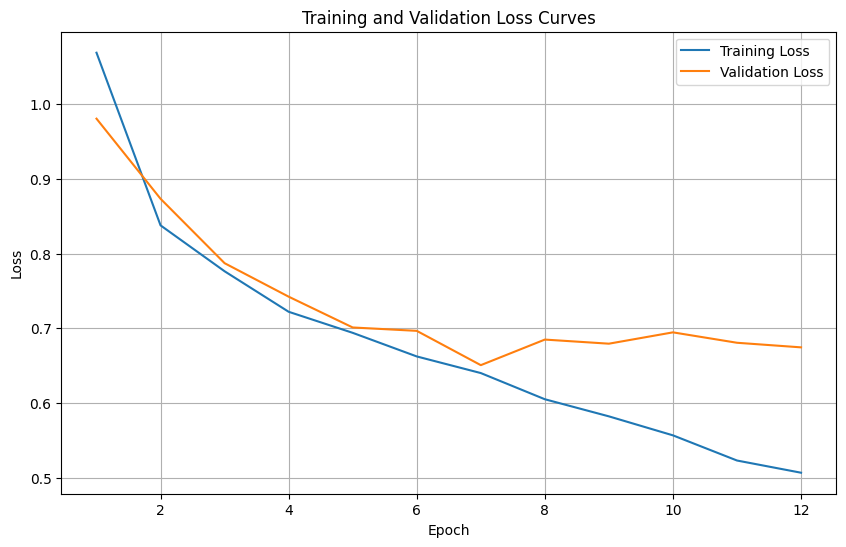


Classification Report:
               precision    recall  f1-score   support

       angry       0.80      0.71      0.75       140
       happy       0.73      0.78      0.75       148
     relaxed       0.69      0.75      0.72       146
         sad       0.85      0.81      0.83       138

    accuracy                           0.76       572
   macro avg       0.77      0.76      0.77       572
weighted avg       0.77      0.76      0.76       572



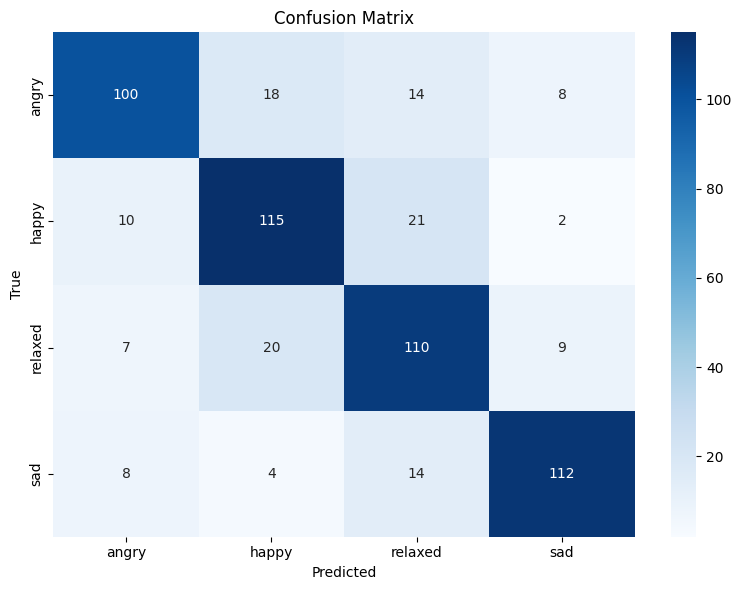

In [24]:
# load best model from training
final_model.load_state_dict(torch.load(best_model_path))
final_model.to(device)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plotting training and validation loss curves
if 'train_losses' in globals() and 'val_losses' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join("..", "results", "efficientnetb5", "loss_curves.png") #NOTE: specify by model name
    plt.savefig(loss_curve_path)
    plt.show()
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path)
else:
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.")

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join("..", "results", "efficientnetb5", "confusion_matrix.png") #NOTE: specify by model name
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)